In [1]:
from typing import *
import time
import random
import numpy as np
import matplotlib.pyplot as plt

from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, Operator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
sim = AerSimulator()

from util import zero, one, enum_bits

# QC: Simon's Algorithm

**Simon's Algorithm** was the first quantum algorithm to demonstrate exponential speedup compared to classical probabilistic algorithm. Thus, it improves upon Deutch-Jozsa and gives hope that there are a class of problems that can be solved with a quantum computer that cannot be solved with a classical computer.

References
1. [Qiskit notebook on Simon's algorithm](https://github.com/Qiskit/textbook/blob/main/notebooks/ch-algorithms/simon.ipynb)

## Problem Formulation

Simon's algorithm solves the problem of determining whether a function is **one-to-one** or **two-to-one**. Similar to Deutsch-Jozsa, Simon's algorithm solves a somewhat contrived problem whose main utility is in showing that it is possible for a quantum algorithm to achieve exponential speedup compared to a classical algorithm.

### One-to-one function

A function $f: \{0, 1\}^n \rightarrow \{0, 1\}^n$ is **one-to-one** if 

$$
f(x) = f(y)
$$

iff $x = y$, i.e., it maps unique bitstrings to unique bitstrings.

In [2]:
# one-to-one
def neg_all(x: list[bool]) -> list[bool]:
    return [not b for b in x]

print(neg_all([False, False]))
print(neg_all([False, True]))
print(neg_all([True, False]))
print(neg_all([True, True]))

[True, True]
[True, False]
[False, True]
[False, False]


In [3]:
# not one-to-one
def f(x: list[bool]) -> list[bool]:
    return [x[len(x)-1]] + [x[i] and x[i+1] for i in range(len(x)-1)]

print(f([False, False])) # <- non-unique
print(f([False, True]))
print(f([True, False]))  # <- non-unique
print(f([True, True]))

[False, False]
[True, False]
[False, False]
[True, True]


### Two-to-one function

A function $f: \{0, 1\}^n \rightarrow \{0, 1\}^n$ is **two-to-one** if for every unique output $z$,

$$
z = f(x) = f(y)
$$

for exactly two $x \neq y$, i.e., it maps each pair of unique bit-strings to the same output.

#### Equivalent formulation

1. Equivalently, let $b \in \{0, 1\}^n \neq 0$ be a bit string. Then $f$ is two-to-one if $f(x) = f(y)$ iff $y = x \oplus b$.
2. Note that $b = 0\dots0$ corresponds to the case that f is a one-to-one function.

In [4]:
def mk_two2one_nbit(n) -> list[bool]:
    b = [True] + [random.choice([True, False]) for i in range(n-1)]
    xs = enum_bits(len(b))
    out = enum_bits(len(b)); random.shuffle(out); i = 0
    mapping = {}; seen = set()
    for x in xs:
        y = [c != d for c, d in zip(x, b)]
        sx = str(x); sy = str(y);
        if sx in seen or sy in seen:
            continue
        mapping[sx] = out[i]; mapping[sy] = out[i]; i += 1
        seen.add(sx); seen.add(sy)
    
    return lambda x: mapping[str(x)]

In [5]:
g2 = mk_two2one_nbit(2)
print(g2([False, False]))
print(g2([False, True]))
print(g2([True, False]))
print(g2([True, True]))

[False, False]
[True, True]
[False, False]
[True, True]


In [6]:
g3 = mk_two2one_nbit(3)
for b in enum_bits(3):
    print(g3(b))

[False, False, False]
[True, True, True]
[True, True, True]
[False, False, False]
[False, False, True]
[True, False, True]
[True, False, True]
[False, False, True]


### Simon's Problem Formulation

Simon's problem is: given a function on bitstrings $f : \{0, 1\}^n \rightarrow \{0, 1\}^n$ that is either
1. a one-to-one function or
2. a two-to-one function,

determine whether it is a one-to-one function or a two-to-one function. Equivalently, given a hidden bit string $b$, determine if $b$ is all 0s or not.

## Classical Solution

Intuitively, the simplest thing we can do is to check every input and see if we get a one-to-one function or a two-to-one function. We actually "only" need to check one more than half of the inputs since we're dealing with two-to-one functions.

In [7]:
def solve_simons(nbits: int, f: Callable[list[bool], list[bool]]) -> str:
    seen = set()
    inputs = enum_bits(nbits)
    count = 0
    for b in inputs:
        # We only need to check half the inputs
        if count >= len(inputs)/2 + 1:
            break
        count += 1
        
        # Keep track of what we have seen
        y = str(f(b))
        if y in seen:
            return "two-to-one"
        seen.add(y)
    return "one-to-one"

In [8]:
solve_simons(3, neg_all)

'one-to-one'

Text(0.5, 1.0, 'Running Time of Classical Algorithm')

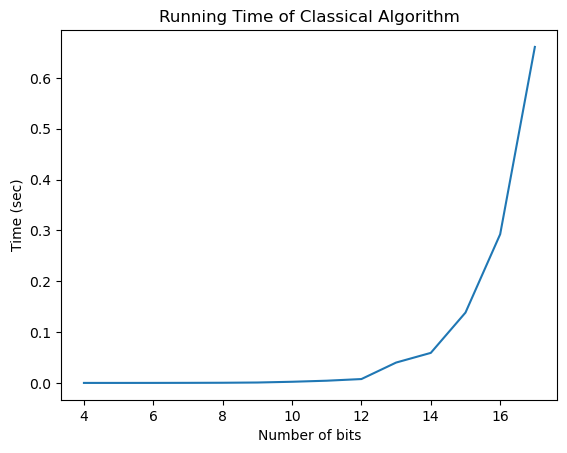

In [9]:
ns = range(4, 18)
times = []
for n in ns:
    start = time.time()
    gn = mk_two2one_nbit(n)
    solve_simons(n, gn)
    times += [time.time() - start]
plt.plot(ns, times)
plt.xlabel('Number of bits'); plt.ylabel('Time (sec)'); plt.title('Running Time of Classical Algorithm')

### Aside: Probabilistic Solution to Simon's Problem

Unlike the Deutsch-Jozsa problem, it is still hard for us to get a speedup, even if we allowed for some error. Intuitively, we still need to check half the bit-strings (in the worst case since the two-to-one can be adversarially constructed), which would still take exponential time.

## Quantum Solution

In this section, we'll walkthrough Simon's algorithm. Simon's algorithm provides an efficient solution to distinguishing between two-to-one or one-to-one functions.

### Walkthrough

We'll use a two qubit example. It will be helpful to separate the initial state

$$
|\psi_0 \rangle = |0\rangle^{\otimes n} \otimes |0\rangle^{\otimes n}
$$

into two parts.

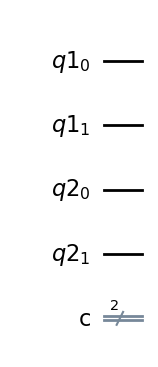

In [10]:
b = "11"
n = len(b)
part1 = QuantumRegister(n, "q1")
part2 = QuantumRegister(n, "q2")
output = ClassicalRegister(n, "c")
simon_circuit = QuantumCircuit(part1, part2, output)
simon_circuit.draw(output="mpl", style="iqp")

### Step 1: Put first n qubits in superposition

Our first step is to the first $n$ qubits in superposition. Towards this end, we apply $H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y|$ to the first $n$ qubits.

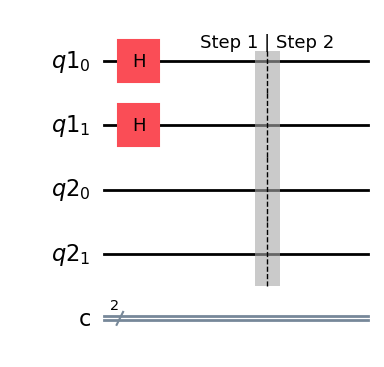

In [11]:
# Step 1: Apply Hadamard gates to first n qubits
simon_circuit.h(range(n))    
simon_circuit.barrier(label="Step 1 | Step 2")
simon_circuit.draw(output="mpl", style="iqp")

#### State after step 1

After we apply step 1, we have the following quantum state

\begin{align*}
|\psi_1 \rangle & = (I^{\otimes n} \otimes H^{\otimes n}) |\psi_0 \rangle \tag{Step 2} \\ 
& = |0\rangle^{\otimes n} \otimes \left( \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y||0\rangle^{\otimes n} \right) \tag{definition $H^{\otimes n}$ and linearity} \\
& = |0\rangle^{\otimes n} \otimes \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} (-1)^{x \cdot |0\rangle^{\otimes n}}|x\rangle \tag{non-zero when $y = |0\rangle^{\otimes n}$} \\
& = |0\rangle^{\otimes n} \otimes \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |x\rangle \tag{dot product is $0$} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |0^{\otimes n}, x\rangle \tag{rearrange}
\end{align*}

### Step 2: Apply Oracle

Apply the oracle

$$
U_f|y, x\rangle = U_f|y \oplus f(x), x\rangle \,.
$$

In [12]:
# Source: https://github.com/qiskit-community/qiskit-textbook/blob/589c64d66c8743c123c9704d9b66cda4d476dbff/qiskit-textbook-src/qiskit_textbook/tools/__init__.py
def simon_oracle(b):
    """returns a Simon oracle for bitstring b"""
    b = b[::-1] # reverse b for easy iteration
    n = len(b)
    qc = QuantumCircuit(n*2)
    # Do copy; |x>|0> -> |x>|x>
    for q in range(n):
        qc.cx(q, q+n)
    if '1' not in b: 
        return qc  # 1:1 mapping, so just exit
    i = b.find('1') # index of first non-zero bit in b
    # Do |x> -> |s.x> on condition that q_i is 1
    for q in range(n):
        if b[q] == '1':
            qc.cx(i, (q)+n)
    return qc 

oracle = simon_oracle(b)

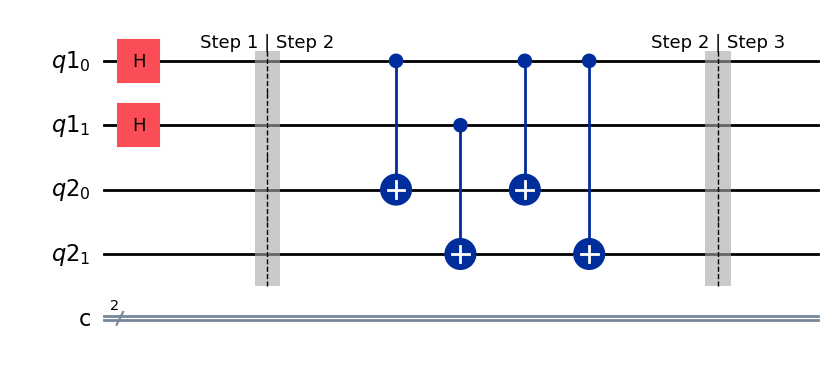

In [13]:
# Step 2: Query Oracle
simon_circuit = simon_circuit.compose(oracle)
simon_circuit.barrier(label="Step 2 | Step 3")
simon_circuit.draw(output="mpl", style="iqp")

#### After step 2

After we apply the oracle, we have the following quantum state

\begin{align*}
|\psi_2\rangle & = H^{\otimes n} |\psi_1\rangle \tag{Step 3} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} U_f |0^{\otimes n}, x\rangle \tag{definition $H^{\otimes n}$ and linearity} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |0^{\otimes n} \oplus f(x), x\rangle \tag{apply oracle} \\
& = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} |f(x), x\rangle \tag{property of xor $\oplus$} \,.
\end{align*}

Observe that we have now encoded the result of the oracle as part of a computational basis vector.

### Step 3: Measure second n qubits

Measure the second half of $|\psi_2\rangle$ to obtain $f(x)$. 

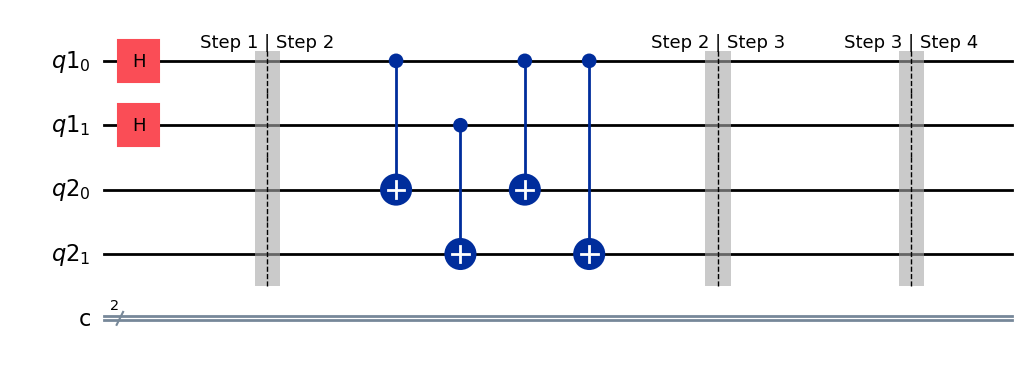

In [14]:
# Can only measure at the end in qiskit
simon_circuit.barrier(label="Step 3 | Step 4")
simon_circuit.draw(output="mpl", style="iqp")

#### After step 3

After measuring the second half of $|\psi_2\rangle$ to obtain $f(x)$, this means either $x$ or $y = x \oplus b$ could be the corresponding input. Therefore the first half of $|\psi_2\rangle$ becomes

$$
|\psi_3\rangle = \frac{1}{\sqrt{2}} (|x\rangle + |y\rangle)
$$

so that the entire quantum state is

$$
|f(x) \rangle \otimes |\psi_3\rangle \,.
$$

### Step 4: Prepare for measurement

Apply $H^{\otimes n} = \frac{1}{\sqrt{2^n}} \sum_{x \in \{0, 1\}^n} \sum_{y \in \{0, 1\}^n}(-1)^{x \cdot y} |x\rangle\langle y|$ to the first $n$ qubits, i.e., $|\psi_3\rangle$ to prepare for measurement.

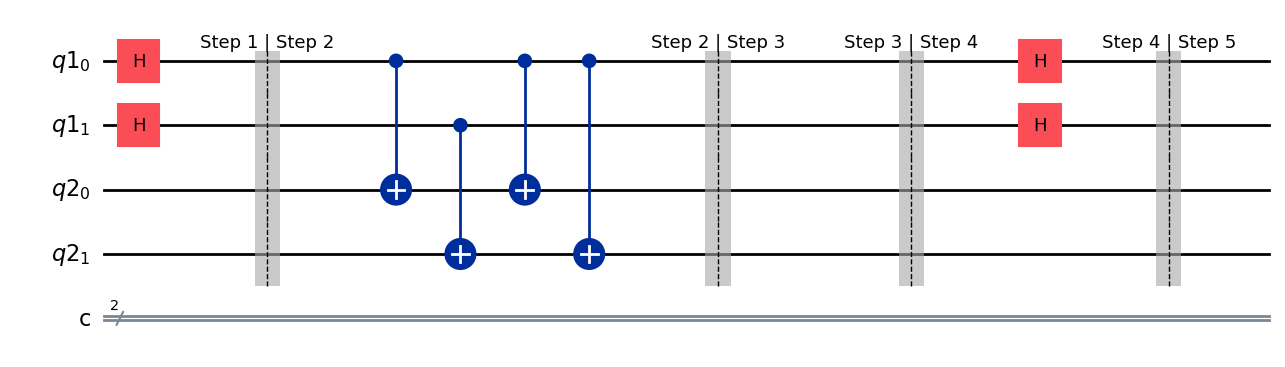

In [15]:
simon_circuit.h(range(n))
simon_circuit.barrier(label="Step 4 | Step 5")
simon_circuit.draw(output="mpl", style="iqp")

#### State after step 4

After step 4, we obtain the following quantum state 

\begin{align*}
|\psi_4\rangle & = H^{\otimes n} |\psi_3\rangle \tag{Step 5} \\
& = H^{\otimes n} \frac{1}{\sqrt{2}} (|x\rangle + |y\rangle) \tag{substitute $|\psi_4\rangle$} \\
& = \frac{1}{\sqrt{2^{n+1}}} \sum_{w \in \{0, 1\}^n} \sum_{z \in \{0, 1\}^n}(-1)^{w \cdot z} |w\rangle\langle z|(|x\rangle + |y\rangle) \tag{definition H and linearity} \\
& = \frac{1}{\sqrt{2^{n+1}}} \sum_{w \in \{0, 1\}^n} ((-1)^{w \cdot x} + (-1)^{w \cdot y}) |w\rangle \tag{dot product not zero when z = x or z = y} \,.
\end{align*}

We have "leaked" the dot product $w \cdot x$ and $w \cdot y$ into the phase of $|\psi_4\rangle$.

#### Step 5: Measure first n qubits

The last step in the algorithm is to measure the first n qubits.

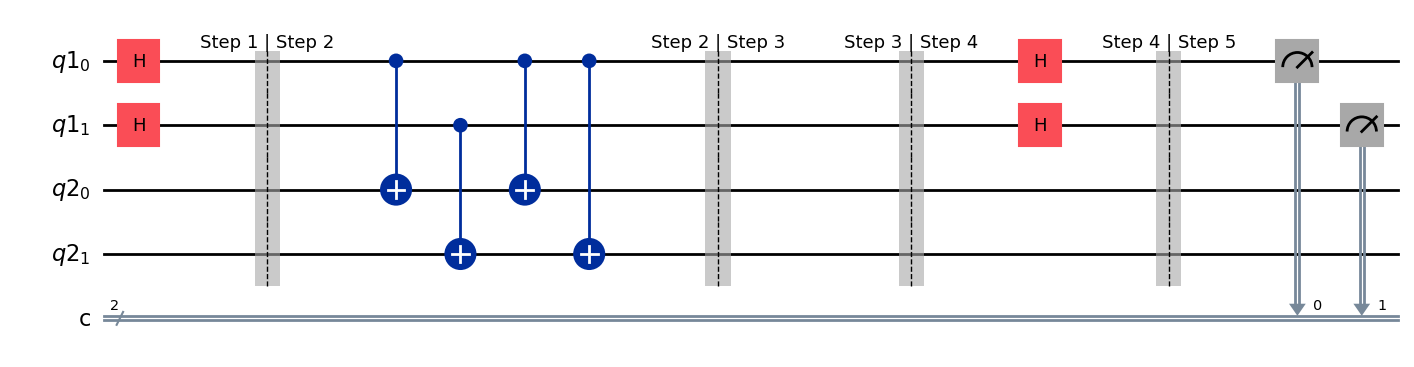

In [16]:
simon_circuit.measure(range(n), range(n))
simon_circuit.draw(output="mpl", style="iqp")

#### Interpreting the results

Observe:
1. $(-1)^{w \cdot x} = (-1)^{w \cdot y}$: contribution of corresponding $|a\rangle$
2. $(-1)^{w \cdot x} \neq (-1)^{w \cdot y}$: no contribution of corresponding $|w\rangle$

Consequently, upon a single measurement, we will observe some $|w\rangle$ s.t. $w \cdot x = w \cdot y$.
This occurs
\begin{align*}
w \cdot x = a \cdot y & \iff w \cdot x = w \cdot (x \oplus b) \tag{substitute y} \\
& \iff w \cdot x = (w \cdot x) \oplus (w \cdot b) \tag{property of xor $\oplus$} \\
& \iff 0 = w \cdot b \,. \tag{xor both sides by $(w \cdot x)$} \\
\end{align*}

Thus with $\approx n$ queries, we obtain a system of linear equations
\begin{align*}
w_1 \cdot b & = 0 \tag{measurement 1}\\
\vdots & = 0 \\
w_n \cdot b & = 0 \tag{measurement n}\\
\end{align*}

This can be solved in $O(n^3)$ time.

In [17]:
# Calculate the dot product of the results
def bdotz(b, z):
    # Source: https://qiskit.org/textbook/ch-algorithms/simon.html
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

11.00 = 0 (mod 2)
11.11 = 0 (mod 2)


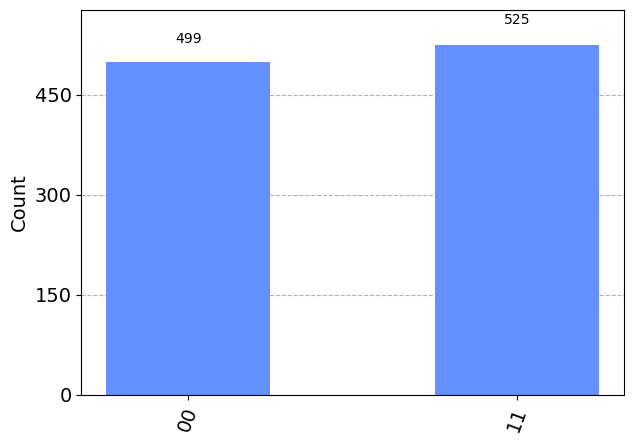

In [18]:
results = sim.run(simon_circuit, shots=1024).result()
counts = results.get_counts()
for z in counts:
    print("{}.{} = {} (mod 2)".format(b, z, bdotz(b,z)))
plot_histogram(counts)

### Putting it together

We provide the full algorithm below.

In [19]:
def simons(b: str) -> QuantumCircuit:
    n = len(b)
    oracle = simon_oracle(b)
    part1 = QuantumRegister(n, "q1")
    part2 = QuantumRegister(n, "q2")
    output = ClassicalRegister(n, "c")
    simon_circuit = QuantumCircuit(part1, part2, output)

    # Step 1: Apply Hadamard gates to first n qubits
    simon_circuit.h(range(n))    
    simon_circuit.barrier(label="Step 1 | Step 2")

    # Step 2: Query Oracle
    simon_circuit = simon_circuit.compose(oracle)
    simon_circuit.barrier(label="Step 2 | Step 3")

    # Step 3: Can only measure in qiskit at the end, but these results are ignored
    simon_circuit.barrier(label="Step 3 | Step 4")

    # Step 4: Apply Hadamard gates to first n qubits
    simon_circuit.h(range(n))  
    simon_circuit.barrier(label="Step 4 | Step 5")

    # Step 5: Measure first n qubits
    simon_circuit.measure(range(n), range(n))
    
    return simon_circuit

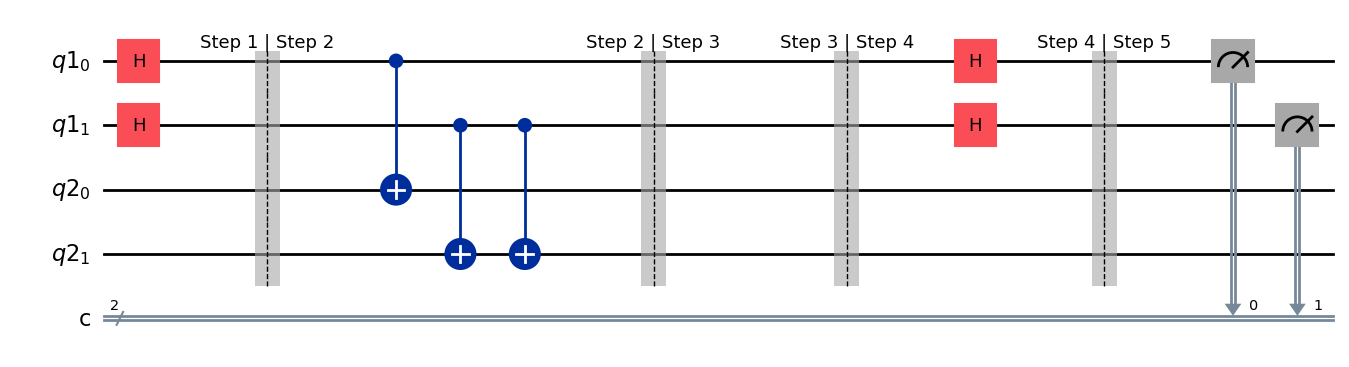

In [20]:
simon_circuit2 = simons("10")
simon_circuit2.draw(output="mpl", style="iqp")

11.00 = 0 (mod 2)
11.11 = 0 (mod 2)


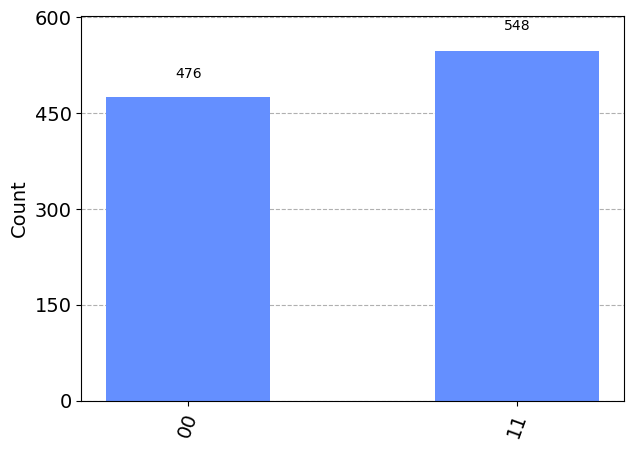

In [21]:
results = sim.run(simon_circuit, shots=1024).result()
counts = results.get_counts()
for z in counts:
    print("{}.{} = {} (mod 2)".format(b, z, bdotz(b,z)))
plot_histogram(counts)

## Summary

1. The classical algorithm for solving Simon's problem requires an exponential number of queries.
2. The quantum algorithm for solving Simon's problem requires just a single query.
3. Simon's algorithm is contrived. Nevertheless, it inspired Shor's algorithm, which is useful.